In [27]:
from itertools import product
import json
import os
import re

import matplotlib.pyplot as plt
import numpy as np

In [28]:
RESULTS_DIR = "games_descriptions/base/output/moderated"
BASE_DIR = "games_descriptions/base/output/base"
GAME_DIR = "games_descriptions/base"
NUM_ISSUES = 5

In [29]:
class Scorer:
    """
    In charge of scoring the options
    """
    def __init__(self, game_dir: str, name_map: dict[str, str] = None):
        self.scores, self.thresholds = self.load_scores_dicts(game_dir)

        self.name_map = name_map if name_map else {}

    def load_scores_dicts(self, game_dir: str) -> tuple[dict[str, int], dict[str, list[list[int]]]]:
        """
        Loads all the scores files from the game directory.
        Creates a dictionary of scores mapping an agent name to a list of lists where the first index is the issue and the
        second index is the option for that issue.
        Also creates a dictionary of thresholds mapping an agent name to their score threshold.
        """
        scores = {}
        thresholds = {}
        for score_file in os.listdir(game_dir + "/scores_files"):
            score_name = score_file.split(".")[0]
            with open(game_dir + "/scores_files/" + score_file, "r") as f:
                # Iterate over each issue
                i = 0
                all_scores = []
                for line in f.readlines():
                    # All lines up to the last are scores for each issue
                    if i < NUM_ISSUES:
                        issue_scores = line.strip().split(",")
                        issue_scores = [int(score) for score in issue_scores]
                        all_scores.append(issue_scores)
                    # Last line is threshold
                    else:
                        thresholds[score_name] = int(line.strip())
                    i += 1
                scores[score_name] = all_scores
        return scores, thresholds

    def score_options(self, agent_name: str, options: list[int]) -> int:
        """
        Takes the list of selected options by an agent and scores them based on the scores list.
        """
        if agent_name in self.name_map:
            agent_name = self.name_map[agent_name]
        score = 0
        for option, option_scores in zip(options, self.scores[agent_name]):
            score += option_scores[option-1]  # Adjust for indexing
        return score
    
    def check_threshold(self, agent_name: str, options: list[int]):
        """
        Checks if the given score exceeds the threshold
        """
        if agent_name in self.name_map:
            agent_name = self.name_map[agent_name]
        score = self.score_options(agent_name, options)
        return score >= self.thresholds[agent_name]
    
    def get_max_total(self) -> tuple[int, int]:
        """
        Returns the highest possible scores for the game.
        Gets all the possible deal options and then brute-force calculates the score for each option.
        """
        # Get all possible options
        dummy_key = next(iter(self.scores))
        dummy_scores = self.scores[dummy_key]
        n_options = [len(options) for options in dummy_scores]
        options = [list(range(1, n + 1)) for n in n_options]
        products = list(product(*options))
        max_total = 0
        max_passed = 0
        best_deal = None
        for option in products:
            # Check total score for this option
            total = 0
            for agent_name in self.scores:
                score = self.score_options(agent_name, option)
                total += score
            if total > max_total:
                max_total = total
                best_deal = option

            # Check number of agents that pass the threshold
            passed = 0
            for agent_name in self.scores:
                if self.check_threshold(agent_name, option):
                    passed += 1
            if passed > max_passed:
                max_passed = passed
        
        return {"score": max_total, "passed": max_passed, "deal": best_deal}
        

NAME_MAP = {
    "Department of Tourism": "DoT",
    "Environmental League": "enviroment",
    "Mayor": "mayor",
    "Other cities": "other_cities",
    "SportCo": "SportCo",
    "Local Labour Union": "union"
}
scorer = Scorer(GAME_DIR, NAME_MAP)

In [30]:
with open(RESULTS_DIR + "/history16_32_41.json", "r") as f:
    history = json.load(f)

with open(BASE_DIR + "/history10_40_45.json", "r") as f:
    base_history = json.load(f)

In [31]:
def extract_deals(history: dict) -> list[dict[str, str]]:
    """
    Extract deals from the history of rounds.
    Gets the text between <DEAL> and </DEAL> in the public answer.
    Splits by commas to get the individual parts of the deal, then strips off the letters to just get the number values.
    """
    deals = []
    for round in history["rounds"]:
        public_answer = round["public_answer"]
        # Deal is between <DEAL> and </DEAL>
        deal_match = re.search(r"<DEAL>(.*?)</DEAL>", public_answer, re.DOTALL)
        if deal_match:
            deal = deal_match.group(1).strip()
            parts = deal.split(",")
            # Use regex to extract numbers from each part
            parts = [int(re.sub(r"[^\d.]", "", part.strip())) for part in parts if part.strip()]
            if parts:
                deals.append({"agent": round["agent"], "deal": parts})
            else:
                raise ValueError("Unable to parse deal")
        else:
            raise ValueError("No deal found")
    return deals

In [32]:
deals = extract_deals(history)
base_deals = extract_deals(base_history)

In [33]:
true_final_deal = deals[-1]["deal"]
final_scores = {}
for agent_name in NAME_MAP.keys():
    score = scorer.score_options(agent_name, true_final_deal)
    final_scores[agent_name] = score
print(f"final deal: {true_final_deal}, scores: {final_scores}, total: {sum(final_scores.values())}")
best_result = scorer.get_max_total()
print(f"Theoretical best: {best_result["deal"]}, total score: {best_result["score"]}")

final deal: [2, 3, 4, 3, 4], scores: {'Department of Tourism': 97, 'Environmental League': 77, 'Mayor': 38, 'Other cities': 32, 'SportCo': 60, 'Local Labour Union': 38}, total: 342
Theoretical best: (2, 3, 1, 1, 1), total score: 412


In [34]:
print(scorer.scores)

{'DoT': [[0, 11, 5], [0, 20, 25], [0, 2, 4, 9], [10, 26, 40, 0], [4, 8, 15, 12, 0]], 'union': [[15, 20, 0], [0, 0, 0], [42, 35, 25, 0], [30, 20, 10, 0], [2, 4, 6, 8, 0]], 'SportCo': [[14, 8, 0], [11, 7, 0], [0, 5, 10, 17], [35, 29, 20, 0], [0, 5, 10, 15, 23]], 'mayor': [[14, 8, 0], [12, 8, 0], [24, 18, 12, 0], [40, 30, 23, 0], [0, 2, 4, 7, 10]], 'enviroment': [[0, 22, 45], [0, 25, 55], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0, 0]], 'other_cities': [[0, 4, 10], [0, 0, 0], [12, 8, 6, 0], [0, 8, 13, 18], [60, 45, 30, 15, 0]]}


In [35]:
deal = deals[-1]
print(deal)
print(scorer.score_options(deal["agent"], deal["deal"]))
print(scorer.check_threshold(deal["agent"], deal["deal"]))

{'agent': 'SportCo', 'deal': [2, 3, 4, 3, 4]}
60
True


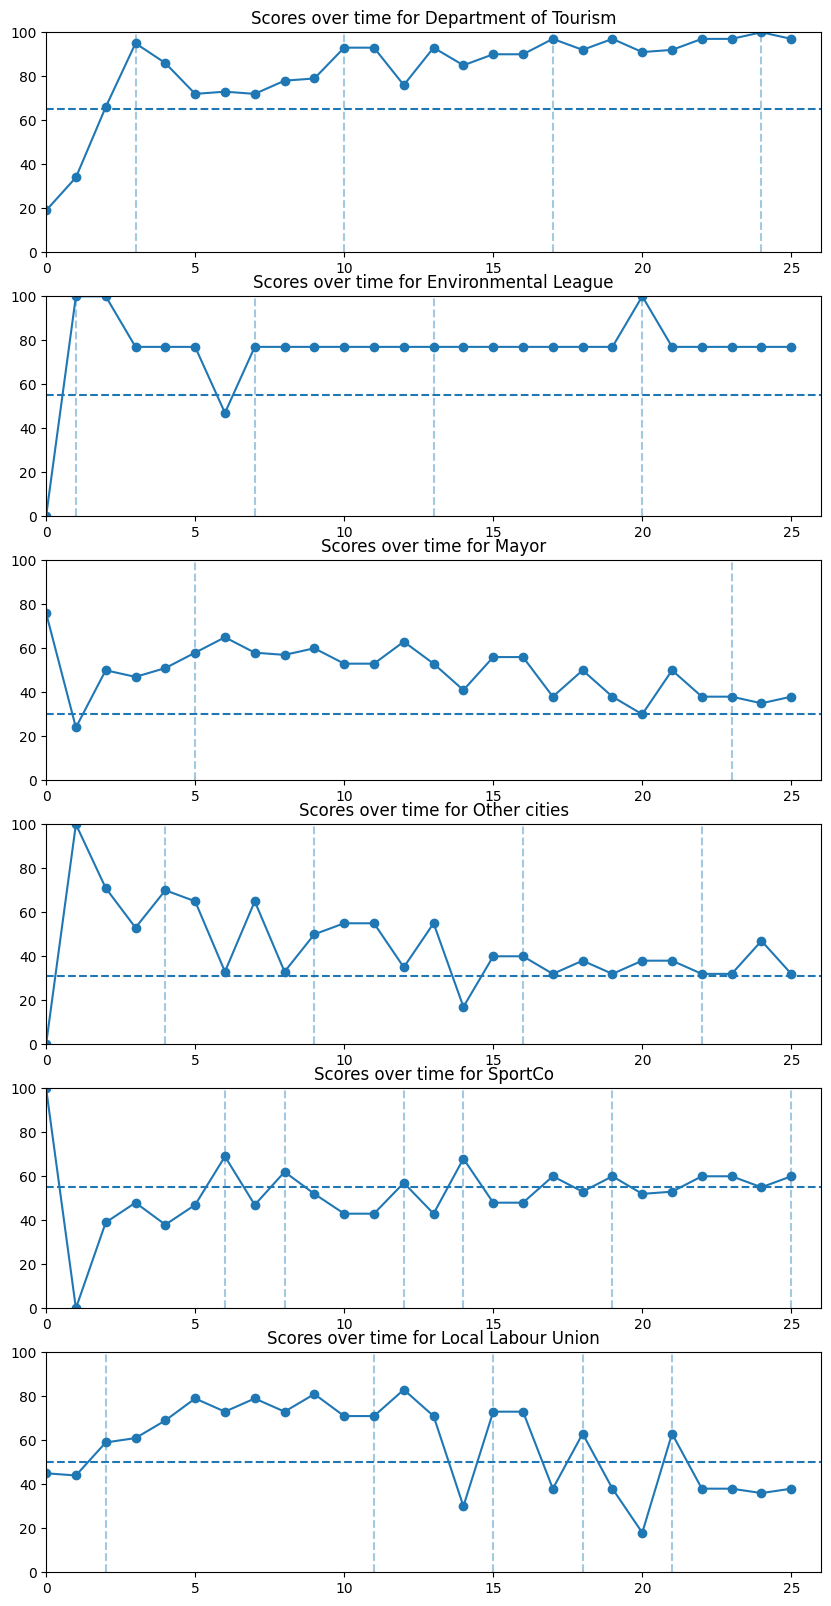

In [36]:
def plot_speaker(ax: plt.Axes, selected_agent: str, history: list[dict]) -> plt.Axes:
    for x, deal in enumerate(history):
        if deal["agent"] == selected_agent:
            ax.axvline(x, label=deal["agent"], linestyle="--", alpha=0.4)
    return ax

def plot_scores(ax: plt.Axes, selected_agent: str, deals: list[dict], scorer: Scorer) -> plt.Axes:
    
    scores = []
    for deal in deals:
        score = scorer.score_options(selected_agent, deal["deal"])
        scores.append(score)
    ax.plot(scores, marker="o")

    threshold = scorer.thresholds[NAME_MAP[selected_agent]]
    ax.axhline(threshold, linestyle="--")

    return ax

def analyze_speaker(ax: plt.Axes, speaker: str, deals: list[dict], scorer: Scorer) -> plt.Axes:
    ax.set_ylim(0, 100)
    ax.set_xlim(0, len(deals))
    ax = plot_speaker(ax, speaker, deals)
    ax = plot_scores(ax, speaker, deals, scorer)
    ax.set_title(f"Scores over time for {speaker}")

fig, axes = plt.subplots(6, 1, figsize=(10, 20))
axes = axes.flatten()
for ax, agent in zip(axes, NAME_MAP.keys()):
    ax = analyze_speaker(ax, agent, deals, scorer)

plt.show()

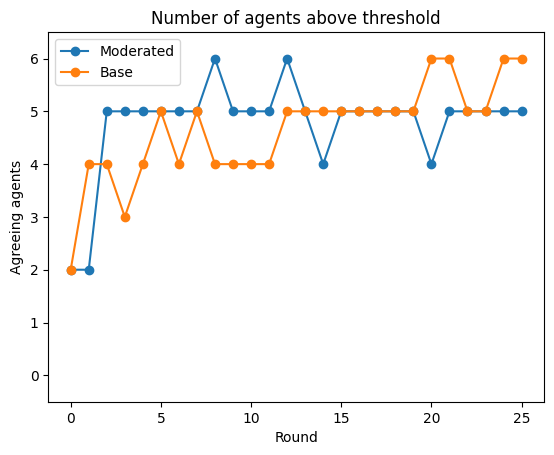

In [52]:
def plot_num_agreed(ax: plt.Axes, deals: list[dict], scorer: Scorer, label: str = None) -> plt.Axes:
    """
    Plots the number of agents that have passed their threshold.
    """
    num_agreed = []
    for deal in deals:
        passed = 0
        for agent_name in NAME_MAP.keys():
            if scorer.check_threshold(agent_name, deal["deal"]):
                passed += 1
        num_agreed.append(passed)

    kwargs = {}
    if label:
        kwargs["label"] = label

    ax.plot(num_agreed, marker="o", **kwargs)
    ax.set_ylim(-0.5, len(NAME_MAP)+0.5)
    ax.set_title("Number of agents above threshold")
    ax.set_xlabel("Round")
    ax.set_ylabel("Agreeing agents")
    if label:
        ax.legend()
    return ax

fig, ax = plt.subplots()
ax = plot_num_agreed(ax, deals, scorer, label="Moderated")
ax = plot_num_agreed(ax, base_deals, scorer, label="Base")
plt.show()

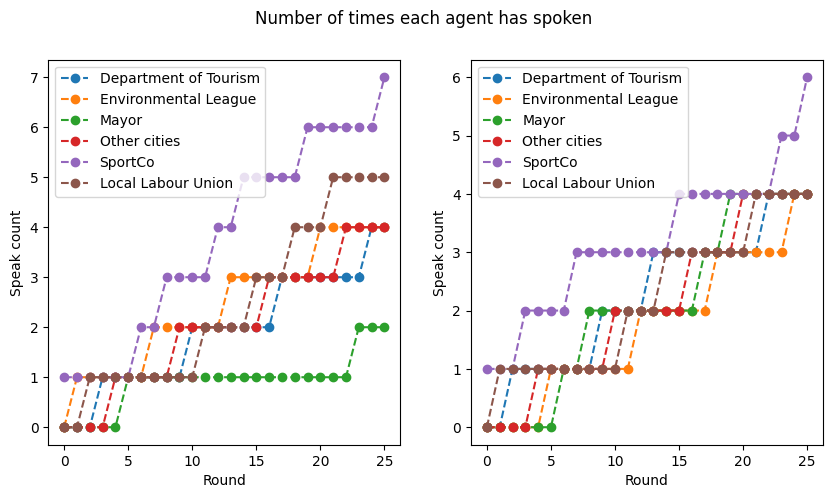

In [44]:
def plot_speak_count(ax: plt.Axes, deals: list[dict]) -> plt.Axes:
    """
    Plots the number of time each agent has spoken as a function of time.
    """
    speak_count = {agent: [0] for agent in NAME_MAP.keys()}
    for deal in deals:
        speaker = deal["agent"]
        # The speaker's count is incremented by 1, others remain the same
        for agent, counter in speak_count.items():
            if agent == speaker:
                counter.append(counter[-1] + 1)
            else:
                counter.append(counter[-1])
    
    # Remove the initial zeroes
    for counts in speak_count.values():
        counts.pop(0)
    
    for agent, counts in speak_count.items():
        ax.plot(counts, label=agent, marker="o", linestyle="--")

    ax.set_xlabel("Round")
    ax.set_ylabel("Speak count")
    ax.legend()
    return ax

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0] = plot_speak_count(axes[0], deals)
axes[1] = plot_speak_count(axes[1], base_deals)
fig.suptitle("Number of times each agent has spoken")
plt.show()
            